In [1]:
import arviz as az
import bambi as bmb
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [2]:
%matplotlib inline
plt.style.use("intuitivebayes.mplstyle")

mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.spines.left"] = False
FIGSIZE = (12, 7)

# Section 10: Introduction

In this lesson, we'll imagine we are working in the data science team of an e-commerce company. In particular, we sell really good and fresh fish to our clients (mainly fancy restaurants).

Lol! Does it sound familiar?

* Of course! We're in a very similar setting than in the previous lesson
* But it's for a good reason!

In the previous lesson, we worked following these steps:

* Exploratory Data Analysis
* Planning
* Model development
    * Propose model
    * Fit model
    * Evaluate fit
    * Inspect inferences
* Insight extraction & communication

Today, we're focusing on Model development only, because we're learning how to use a fantastic new tool: Bambi

# Section 20: The world's simplest model, now simpler

## First things first

In [3]:
data = pd.read_csv("data/fish-market.csv")
data = data[data["Weight"] > 0].reset_index(drop=True)
data

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
153,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
154,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
155,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
156,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


Let's quickly load the data frame and remove the observation with the null weight.

## Intercept only model

$$
\begin{aligned}
\text{Weight}_i &= \beta_0 + \varepsilon_i \\
\varepsilon_i & \sim \text{Normal}(0, \sigma) 
\end{aligned}
$$

In [4]:
model = bmb.Model("Weight ~ 1", data)

Let's create the intercept only model using Bambi. As you can see, it fits in a single line. We only need to pass a formula describing the model and the data frame with the data. We'll come back to the details in just a moment.

## Fit

In [5]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, Weight_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


Yes, it's that simple. How cool is that? No need to miss you beloved scikit-learn API anymore. Bambi brings back the nice `.fit()` method. 

And something else, doesn't the sampler message look familiar to you? It's because Bambi is working with a PyMC model under the hood! So whenever we fit a Bambi model, we're actually fitting a PyMC one!

## What's in the returned object?

In [6]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

As PyMC does, Bambi also returns an `InferenceData`. It contains similar information than the `InferenceData` objects we obtain when working with PyMC models directly. We have the following groups

* posterior: Draws from the posterior distribution
* log_likelihood: The log likelihood evaluated at every draw of the posterior
* sample_stats: Statistics of the sampler 
* observed_data: The fish weights

We're mostly interested in the posterior for now. 

## The posterior

In [7]:
idata.posterior

<xarray.Dataset>
Dimensions:       (chain: 2, draw: 1000)
Coordinates:
  * chain         (chain) int64 0 1
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    Intercept     (chain, draw) float64 430.1 435.7 435.7 ... 394.3 401.5 395.5
    Weight_sigma  (chain, draw) float64 348.3 345.3 345.3 ... 320.4 382.9 355.4
Attributes:
    created_at:                  2022-11-23T02:54:47.303203
    arviz_version:               0.12.1
    inference_library:           pymc
    inference_library_version:   4.1.5
    sampling_time:               4.48614764213562
    tuning_steps:                1000
    modeling_interface:          bambi
    modeling_interface_version:  0.9.1

$$
\begin{aligned}
\beta_0 & \sim \text{Normal}(0, \sigma_{\beta_0}) \\
\sigma & \sim \text{HalfNormal}(\sigma_\varepsilon) \\
\text{Weight}_i & \sim \text{Normal}(\beta_0, \sigma) 
\end{aligned}
$$

There are two parameters: one called Intercept and other called Weight_sigma. If we have a second look at the distributional representation of the model, we can see they match $\beta_0$ and $\sigma$.

## It's simply InferenceData

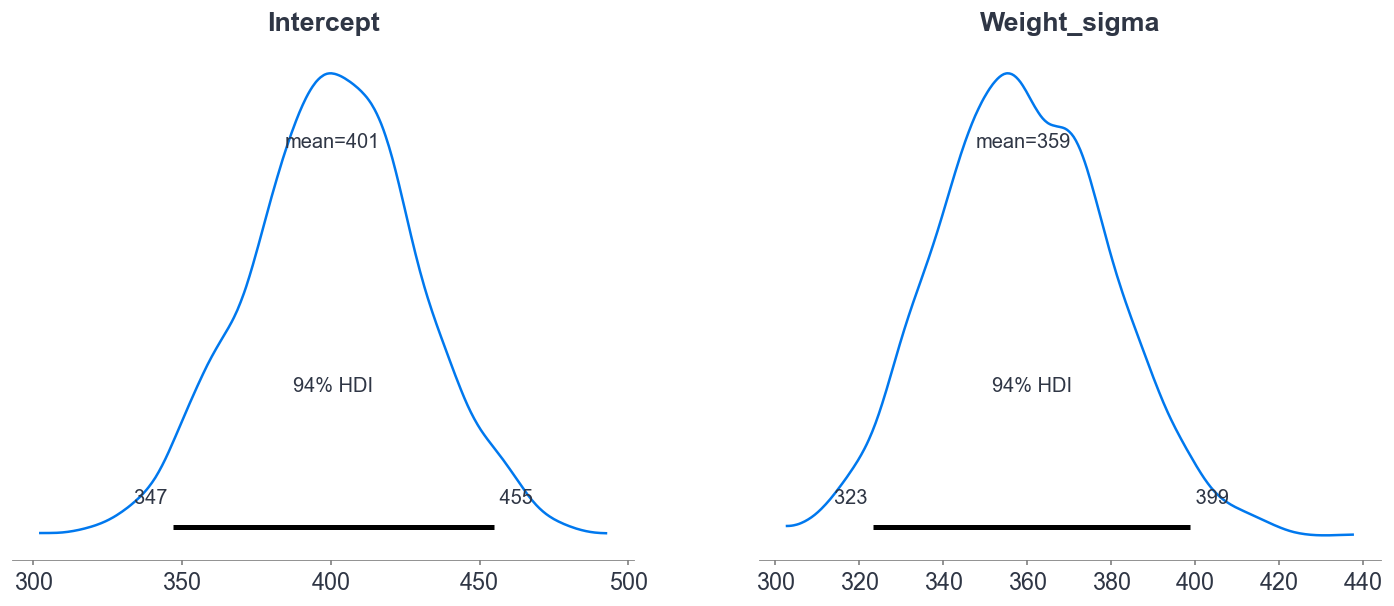

In [8]:
az.plot_posterior(idata);

It's ArviZ friendly. We can use all the ArviZ functions we love using with PyMC models. It's the same type of object, so expect to be able to to the same!

Let's have a look at the marginal posteriors now. Does it look familiar? Does it match the values we got in our previous lesson? 

* The posterior of the Intercept is very similar, it's just a little wider
* The posterior of Sigma is around larger values. Looks like the priors we had for the PyMC model were more restrictive than the priors here.

## What did we do?

* We created a Bambi model
* It's a one liner

The basics of a Bambi model are

* A model formula
    * The specification of the response and predictors
* A data frame
    * Where we extract variables from

**Note:** I would like to create a visual representation (with draw.io)

## Model formula

**Note** A graph here as well. Maybe two. One generic and another one for the model we've just built.

The model formula is a concise and clear representation of the response and the predictors of a statistical model. One of it's main characteristics is the tilde operator (`~`). It separates the response from the predictors. Anything on left hand side is part of the response, and anything on the right hand side is part of the predictors.

In this lesson we're going to cover many details about the predictors part of the formula. But we have already covered something special! The "1" on the right hand side is not the name of any predictor, right? However, this is how you tell Bambi that you want an intercept.

**Optional?**

If you want to understand why it's the one, you can think of it as a predictor that is always equal to one. In the end, multiplying a coefficient by 1 is not going to change it, and that's exactly what happens with the intercept. 

## Comparison with the PyMC model

In [9]:
with pm.Model() as pm_model:
    intercept = pm.Normal("Intercept", sigma=200)
    sigma = pm.HalfNormal("sigma", sigma=100)
    pm.Normal("Weight", mu=intercept, sigma=sigma, observed=data["Weight"])

In [10]:
bmb_model = bmb.Model("Weight ~ 1", data)

It's 4 lines of code versus 1. That's a huge difference!

But there's something that feels like cheating. We're simply not writing priors in Bambi. Why is that? Is it because it's non Bayesian? 

The answer is it is Bayesian, but Bambi provides automatic priors so you it's not strictly required to tell it priors manually. This is a huge topic itself, and it's going to be covered in much more detail towards the end of the lesson. For now, it's good to know that Bambi does use the Bayesian approach, but it just makes it a little easier for us so we can iterate faster and write less code. Obviously, once we get to use it more seriously, it will be good to specify our own priors.

## Section Recap

* We've introduced Bambi
* Bambi models are made of two basic components
    * A formula
    * A data frame
* Benefits of Bambi
    * More concise syntax
    * Provides automatic priors
    * Allows iterating quicker
* It's a PyMC model under the hood

Under the hood, it's just a PyMC model. Bambi takes care of all the complicated internal details.

## Section 30: What's in a Bambi model

In the previous section we saw it's very easy to create models with Bambi. But we know very little about the details. The goal of this section is to get more familiar with these models so we can feel more comfortable when working with them.

## Print the model

In [11]:
model = bmb.Model("Weight ~ 1", data)

In [12]:
model

Formula: Weight ~ 1
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 400.8475, sigma: 891.4101)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 356.564)

Previously, we created an intercept-only regression model using Bambi. We saw it was very concise piece of code. Fitting the model was also so easy. But there's something even cooler. When we print a Bambi model, we get so much information. 

## The formula

Just a reminder of the formula that was used to create the model. If you've just created the model one cell above it's not of much value, but it's really useful if you have several models and you want to make sure what's in each of them.

**Note:** Would be good to show the output, higlighting the part we're talking about in each slide.

## The family

It's a broader concept in Bambi that represents the type of the model. For now, we're happy to see it says "gaussian". This means the model is using a Gaussian likelihood function. 

This is not happening because Bambi is smart enough to read our minds, though! Since Gaussian linear regressions are so popular, the `"gaussian"` family is the default choice. We have so many examples where we use non-default families in the following lessons.

## The link

Similarly to families, it's a very important concept that will not cover in depth in this lesson, because it's very well covered in Lesson 4, when it's actually needed.

In a nutshell, a link is a transformation that is applied to the mean of the likelihood function. It may sound complicated, but believe me, lesson 4 will make it very clear. For now, we're happy knowing it says "identity" which means it doesn't change anything (because it applies the identity function!)

## Observations

Bambi always tells you how many observations entered the model. In some cases, when there are missing values, it's possible the number of observations that are used by Bambi is smaller than the number of rows in the data frame. So this is what it's useful for (plus quickly checking the number of observations in general, without having to look back into the original dataframe)

## Priors

In [13]:
print(model)

Formula: Weight ~ 1
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 400.8475, sigma: 891.4101)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 356.564)


Finally, here are the priors! The first thing we can see is priors come in different groups (common effects and auxiliary parameters). These groups a well defined purpose but it's too early to learn about these more advanced topics. They are very well covered later. What we need to learn now is that whenever we want to check what are the priors in the model, we can print it, and Bambi is going to show us the priors.

The most important things are

* The prior for the `Intercept` is a Normal distribution centered around 400, and sigma equals to 891.
* The prior for `sigma`, the standard deviation of the error term, is a `HalfStudenT` distribution with `nu` equals to 4 and sigma equals to 356.

These values were determined **automatically** by Bambi.

How Bambi chooses priors is a very interesting topic, and there's so much work behind it. We have prepared an appendix that you can find in the end of the Lesson.

## Section Recap

* Bambi models contain so much information
* Printing a model shows a summary
    * It contains the most important pieces of a model
    * It can be used to access information quickly
* ... ?

# Section 40: Slopes

## Prepare the data

In [14]:
data["log_weight"] = np.log(data["Weight"])
data["log_length"] = np.log(data["Length1"])

Bambi is great. It allows us to write models with a simple formula. But variable names must exist in the data frame. So we need to compute the logarithm of the weight and the logarithm of the length and store it as a new column. Then we're ready to build the model!

## Create the model

In [15]:
model = bmb.Model("log_weight ~ 1 + log_length", data)
model

Formula: log_weight ~ 1 + log_length
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 5.41, sigma: 26.3354)
    log_length ~ Normal(mu: 0.0, sigma: 8.1834)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 1.322)

## Build the model

In [16]:
model.build()

The construction of a Bambi model has two steps. 

* Creation of the Bambi model
* Creation of the underlying PyMC model

The first step occurs when we do `bmb.Model()`. The second, can occur implicitly or explicitly. If we call `model.fit()`, the PyMC model is going be built implicitly. But we can also do it in an explicit manner because we want to do other stuff for which we need the PyMC part, like creating a plot of the priors or a graphical representation of the model

## Explore the priors

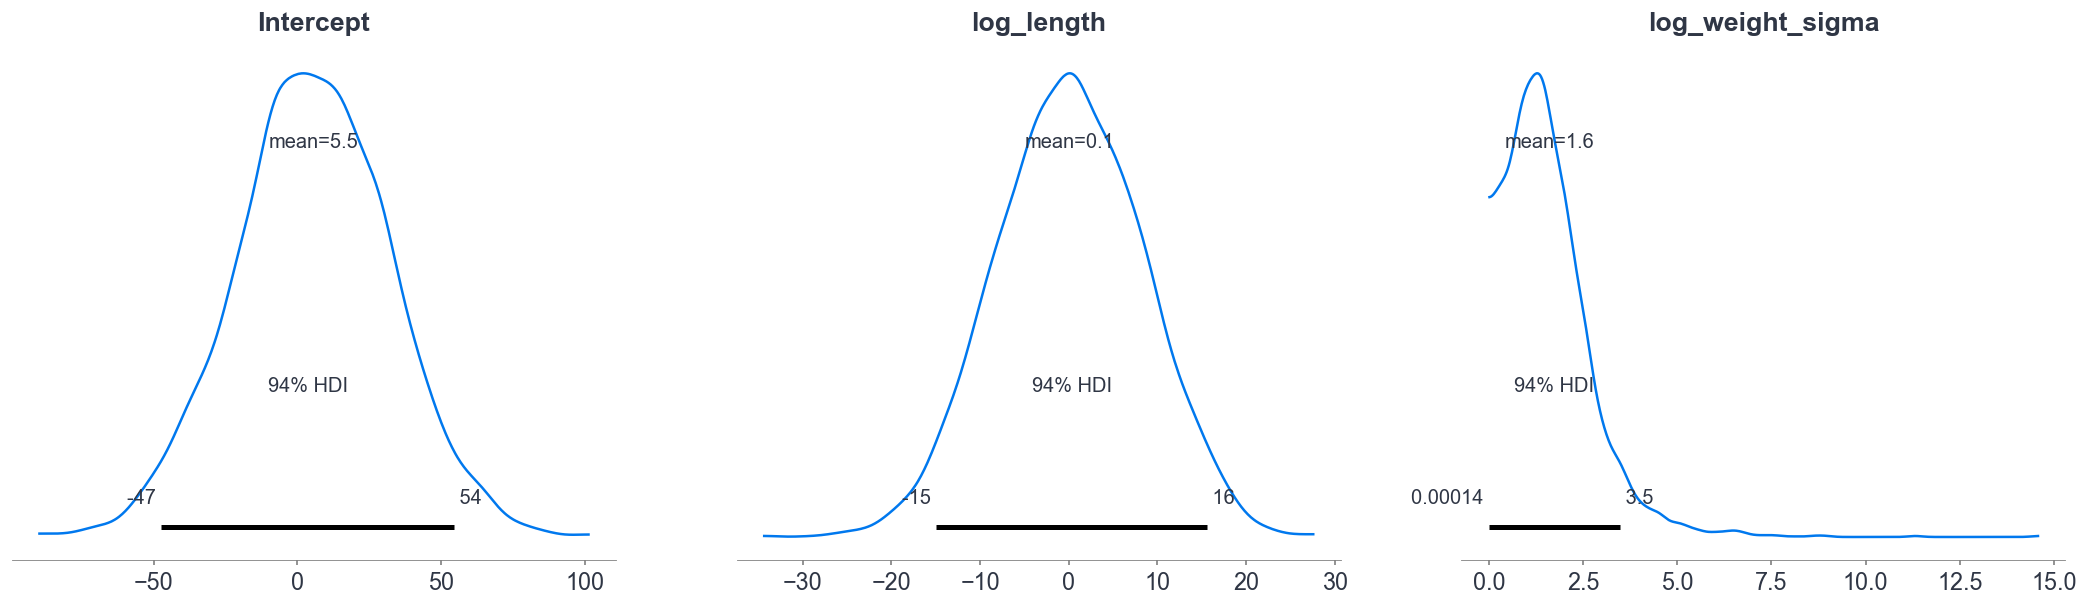

In [17]:
model.plot_priors();

## Graph

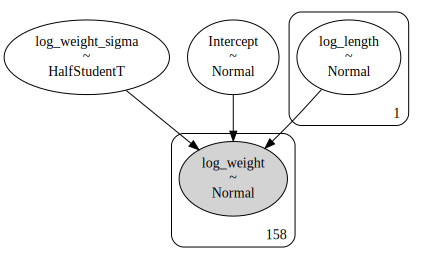

In [18]:
model.graph()

**Note** we need to update Bambi. The '1' there is not a good think. The parameter is not actually one dimensional.

## Fit the model

In [19]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, log_length, log_weight_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [20]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-4.627,0.237,-5.101,-4.212,0.004,0.003,2861.0,1480.0,1.0
log_length,3.144,0.074,3.013,3.289,0.001,0.001,2826.0,1553.0,1.0
log_weight_sigma,0.373,0.021,0.332,0.410,0.000,0.000,2958.0,1319.0,1.0


## Plot the fitted line

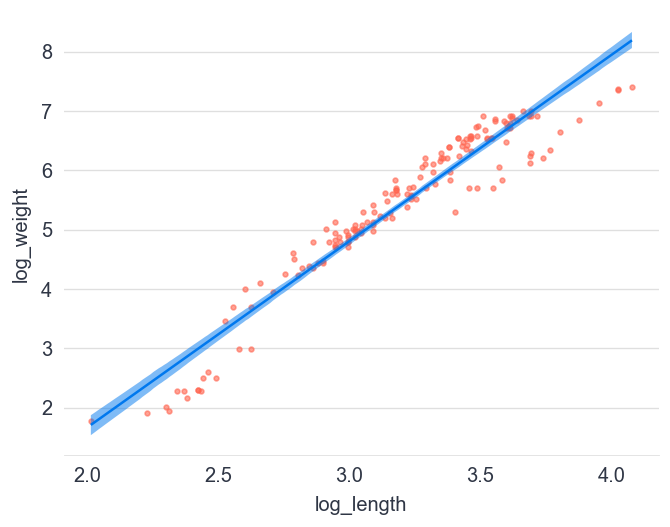

In [21]:
from bambi.plots import plot_cap

fig, ax = plt.subplots()
ax.scatter(data["log_length"], data["log_weight"], color="C4", alpha=0.6, s=8);
plot_cap(model, idata, "log_length", ax=ax);

## Section Recap

* ...

# Section 50: Transformations in Bambi

## Let's be honest

We don't really need to do

```python
data["f_of_x"] = f(data["x"])
bmb.Model("y ~ f_of_x", data)
```

We can simply do 

```python
bmb.Model("y ~ f(x)", data)
```

I actually lied to you. Lol! 

We don't actually need to transform variables and store them in new columns **before** creating the model. 

Transformations are an extremely important topic. And we mean it! 

It's so important that Bambi allows to use inline transformations. It's so cool!

Instead of having to pre-compute transformations, you can simply use the function within the formula. Bambi knows how to handle it :)

## In our model

In [22]:
model = bmb.Model("np.log(Weight) ~ np.log(Length1)", data)
model

Formula: np.log(Weight) ~ np.log(Length1)
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 5.41, sigma: 26.3354)
    np.log(Length1) ~ Normal(mu: 0.0, sigma: 8.1834)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 1.322)

In [23]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, np.log(Length1), np.log(Weight)_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


All that means we can use inline transformations with our model too. Instead of having to precompute the logs, we can simply compute them on the fly within the formula. Bambi knows how to take care of it.

See the inline transformations in action. Do you want transformed variables? It's still one-liner! How cool is that?

## How does it work?

Bambi allows to use two types of transformations

* Functions available in the environment where the model is created
    * Like `np.log()` above

* Built-in functions
    * `center()`
    * `scale()`

Transformations are functions. Transformations are Python functions. Bambi can use two types of transformations. The first, Python functions that are available in the environment where the model is created. Since we have imported NumPy as `np`, we can access `np.log()`. 

But there's more! Bambi also comes with several built-in transformations that make statistical modeling easier. Sometimes one wants to center the variable (subtract the mean) or scale the variable (subtract the mean and divide by the standard deviation). Instead of having to do it manually, or needing to write our own function, that comes already built-in Bambi.

## Important transformations

* `center(x)`

$$
\text{center}(x) = x - \text{mean}(x)
$$

* `scale(x)`

$$
\text{scale}(x) = \frac{x - \text{mean}(x)}{\text{sd}(x)}
$$

* Explain what they are
* Tell briefly when they're recommended
* Say it's better to let Bambi handle these rather than writing our own functions. Not only because the amount of work, but also because of other complexities.

## Custom operations

* What if I want my predictor 
    * Divided by 10?
    * to the second power?

Don't do this 

```python
"y ~ x / 10"
"y ~ x ** 2"
```

Do this

```python
"y ~ I(x / 10)"
"y ~ I(x ** 2)"
```

or this

```python
"y ~ {x / 10}"
"y ~ {x ** 2}"
```

The operators `/` and `**`, as many other operators, have a different meaning in the formula mini-language.  When we want these operators to have the same meaning they would do in Python (or actually, in regular math!) we have to "escape" them. To do that we can use the `I()` function or brackets. Anything written within them will be evaluated as regular Python. 

## Formulas are so powerful

* The response variable

* The predictors

* Transformations!
    * Of several kinds

simplifies communication, reduces misunderstanding... it's a very powerful tool!

## Section Recap

* ...

# Section 60: Modeling categories

## Categorical is not the same as numeric

* Length, Width, Height are numeric
    * Math makes total sense

* Species is categorical
    * Math does not make sense

* We need to treat categorical variables in a different way
    * We did it with PyMC in the previous lesson

## Categorical is the same as numeric

* Bambi makes life easier 

* Using categories is the same

* Bambi knows how to handle all the details for us

## Modeling categories

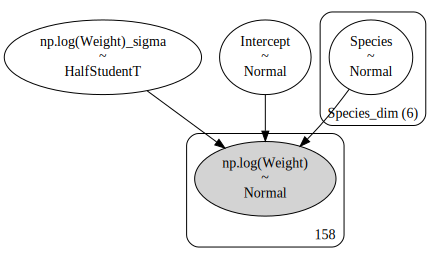

In [24]:
model = bmb.Model("np.log(Weight) ~ 1 + Species", data)
model.build()
model.graph()

## Fit

In [25]:
idata = model.fit()
np.exp(az.summary(idata)["mean"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, Species, np.log(Weight)_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


Intercept               582.890881
Species[Parkki]           0.233868
Species[Perch]            0.403734
Species[Pike]             1.003005
Species[Roach]            0.242926
Species[Smelt]            0.018170
Species[Whitefish]        0.789781
np.log(Weight)_sigma      2.155451
Name: mean, dtype: float64

* Runs very well

But it opens some questions...

## What's going on

In [26]:
np.exp(az.summary(idata)["mean"])

Intercept               582.890881
Species[Parkki]           0.233868
Species[Perch]            0.403734
Species[Pike]             1.003005
Species[Roach]            0.242926
Species[Smelt]            0.018170
Species[Whitefish]        0.789781
np.log(Weight)_sigma      2.155451
Name: mean, dtype: float64

* Why do we have 6 species instead of 7?
* What is the meaning of the species parameters?

## Zoom into the formula

<center>
  <img src="imgs/formula_1_plus_species.png" style="width:60%"; />
</center>

To understand what's going on, and why Bambi is dropping one of the species, we need to understand how the model formula is being mapped onto a statistical model. This is an extremely important part of the course, because it explains complexities of model formulas in deep detail.

We can map the formula to math as follows:

The expectation of the response variable, in this case, the log weight, is equal to the sum of two components

1. An intercept parameter, $\beta_0$. This is the same for all the fish of all species.
1. A Species-specific parameter, $\beta_{1, j}$. 

## Zoom into the formula

<center>
  <img src="imgs/formula_1_plus_species_extended.png" style="width:60%"; />
</center>

* There are 7 species, so we can imagine we have 7 $\beta_1$ parameters
* The expected value for a given species is the sum of the intercept and the species parameter
* Let's see how it works in the following slide

## Mapping

<center>
  <img src="imgs/expected_values_1_plus_species.png" style="width:45%"; />
</center>

The story goes like...

* The mean for the Bream species is the Intercept plus the Bream Beta 1
    * Number of things we want to estimate: 1
    * Number of parameters: 2
        * $\beta_0$ and $\beta_{1, 1}$
* The mean for the Parkki species is the Intercept plus the Parkki Beta 1
    * Number of things we want to estimate: 2
    * Number of parameters: 3
        * $\beta_0$, $\beta_{1, 1}$, and $\beta_{1, 2}$

Until we reach Whitefish. And then **the problem** becomes more evident. We want to estimate 7 means, but we have 8 parameters!

* It is a problem with infinite solutions!
    * In other words: the model is non-identifiable.
* How to make the solution unique? Choose a restriction
    * And this creates a new problem!
    * Which restriction do we choose?

**Animation note:** 

* Reveal line by line, up to the second or third line. 
* Have a count of things we want to estimate (the means) and a count of parameters
* Then it's going to be very clear that we want to estimate 7 things with 8 parameters.

## Reference encoding (what Bambi does by default)

<center>
  <img src="imgs/formula_1_plus_species_extended_with_zero.png" style="width:60%"; />
</center>

* Dropping a level is one of the many constrains one could apply to a categorical variable to make the model identifiable.
* This does not mean the level does not exist anymore.
    * It's there' but its coefficient is zero
    * And that's why it does not appear in the posterior
* By default, Bambi drops the first level of the categorical variable
    * In this case, it's Bream.

## An identified model

<center>
  <img src="imgs/expected_values_1_plus_species_with_zero.png" style="width:45%"; />
</center>

* Number of things to estimate: 7
* Number of parameters: 7
* The problem has a unique solution! That's great!

## So what...

is the meaning of the parameters for the species?

Using the image from the previous slide...

* $\beta_0$ is the mean response for the reference level.
* But $\beta_0$ is also used in the computation of the mean of all the other species.
    * This helps us understand what's the meaning of the species parameters
    * They **are not** the mean of each species
    * But the difference between a given species and the reference species.
    * If we want the mean for a given species, we need to do $\beta_0 + \beta_{1, j}$
    

## Another solution

* For this particular case, there's another solution we can try
* Do we really need an intercept term? What's the purpose?
* Solution: Remove the intercept parameter!

**Leading question:** If the number of parameters is the same than the number of things we want to estimate. Can't we map parameters and quantities more straightforwardly so parameters have a more interpretable meaning?

Also, we didn't have to think about encodings in PyMC... why? (answer: the PyMC model we built is like the one we show next)

## Another solution

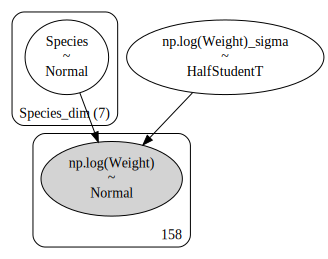

In [27]:
model = bmb.Model("np.log(Weight) ~ 0 + Species", data)
model.build()
model.graph()

In [28]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Species, np.log(Weight)_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [29]:
np.exp(az.summary(idata)["mean"])

Species[Bream]          580.563974
Species[Parkki]         136.592221
Species[Perch]          234.393189
Species[Pike]           582.308281
Species[Roach]          140.611392
Species[Smelt]           10.601548
Species[Whitefish]      459.436161
np.log(Weight)_sigma      2.157608
Name: mean, dtype: float64

* All the species appear now! 
* Why?
* Let's figure it out!

## Another solution

<center>
  <img src="imgs/formula_0_plus_species.png" style="width:60%"; />
</center>

## Another solution

<center>
  <img src="imgs/formula_0_plus_species_extended.png" style="width:60%"; />
</center>

## Mapping a simpler model

<center>
  <img src="imgs/expected_values_0_plus_species.png" style="width:45%"; />
</center>

* 7 quantities to estimate
* 7 parameters
* There's a unique solution without having to impose a restriction!
* Parameters have a one-to-one mapping with quantities of interest
    * Each parameter is the mean of the group!
    * This is way better!

## Section Recap

# Section 70: Understanding encodings

**NOTE:** I got excited writing and I covered most (if not all) concepts in Section 60. But it looks like a very long section. So maybe it's sensible to split Section 60 in two, and make the second part the new Section 70, showing the model with cell means encoding (y ~ 0 + Species)

## Section Recap

# Section 80: The full model

## Section Recap

## Section 90: Predictions

## Section Recap

## Section 100: End to end analysis with Bambi

## Section Recap

# Appendix: Priors in Bambi